In [42]:
import rclpy
import rclpy.logging
from rclpy.node import Node
from actuator_msgs.msg import Actuators
from std_msgs.msg import Header, Int16

from rclpy.qos import QoSProfile, ReliabilityPolicy, HistoryPolicy, DurabilityPolicy
from nav_msgs.msg import Odometry

import numpy as np
import math
from collections import deque

In [43]:
import pandas as pd
from pydrake.all import LinearQuadraticRegulator
from scipy.optimize import root

In [44]:
mass = 2 + 0.016076923076923075 * 4
mass

2.0643076923076924

In [45]:
Ixx_B = 0.02166666666666667
Iyy_B = 0.02166666666666667
Izz_B = 0.04000000000000001

Ixx_P = 3.8464910483993325e-07
Iyy_P = 2.6115851691700804e-05
Izz_P = 2.649858234714004e-05

Ixx_t = Ixx_B + 4 * Ixx_P
Iyy_t = Iyy_B + 4 * Iyy_P
Izz_t = Izz_B + 4 * Izz_P
Ixx_t, Iyy_t, Izz_t

(0.02166820526308603, 0.021771130073433474, 0.04010599432938857)

In [46]:
l = 0.25

In [47]:
global KF, Y
KF = 1.70681338382397e-05           #calculated
# KF = 8.54858e-06           #sdf
Y = 0.0022691848310634915
# Y = 0.0035561456031187356       #drag=2x
# Y = 0.017609016217704738       #drag=10x

In [48]:
moment_constant = 0.016
KT = moment_constant

In [49]:
def quaternion_to_rpy(w, x, y, z):
    """
    Convert quaternion to roll, pitch, and yaw (RPY) angles.
    
    Parameters:
    - x: float, x component of the quaternion
    - y: float, y component of the quaternion
    - z: float, z component of the quaternion
    - w: float, w component of the quaternion
    
    Returns:
    - roll: float, roll angle in radians
    - pitch: float, pitch angle in radians
    - yaw: float, yaw angle in radians
    """
    
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = math.atan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        pitch = math.copysign(math.pi / 2, sinp)  # Use 90 degrees if out of range
    else:
        pitch = math.asin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

In [50]:
class CommandPublisherNode(Node):
    def __init__(self):
        super().__init__('command_publisher_node')
        self.logger = self.get_logger()
        self.motor_command_pub = self.create_publisher(Actuators, '/x500/command/motor_speed', 10)
        
        qos_profile = QoSProfile(
            reliability=ReliabilityPolicy.BEST_EFFORT,
            durability=DurabilityPolicy.VOLATILE,
            history=HistoryPolicy.KEEP_LAST,
            depth=5
        )
        
        # Create subscription with proper QoS
        self.subscription = self.create_subscription(
            Odometry,
            '/x500/odometry',
            self.odometry_callback,
            qos_profile)
        self.initialize_params()
        
    def initialize_params(self):        
        self.actuators_msg = Actuators()
        self.actuators_msg.header = Header()
        self.actuators_msg.header.stamp = self.get_clock().now().to_msg()
        self.actuators_msg.header.frame_id = ''
        self.actuators_msg.velocity = [float(0), float(0), float(0), float(0)]
                
        # Initialize class attributes
        self.clock_time = self.get_clock().now()
        self.x = self.y = self.z = 0.0
        self.vx = self.vy = self.vz = 0.0
        self.prev_vx = self.prev_vy = self.prev_vz = 0.0
        self.ax = self.ay = self.az = 0.0
        self.roll = self.pitch = self.yaw = 0.0
        
        # Previous velocities for acceleration calculation
        self.prev_vx = self.prev_vy = self.prev_vz = 0.0
        
        # Create a rate
        self.frequency = 100
        self.rate = self.create_rate(self.frequency) 
        
        # motor commands
        self.command_values = [0.0, 0.0, 0.0, 0.0]
        self.to_measure_Y = False      #torque coeff
        self.to_measure_KF = False      #force coeff
        self.measurement_queue = deque(maxlen=10)
        self.counter = 0
        # for force coeff
        self.avg_acc_error_tol = 0.01
        self.avg__w__error_tol = 0.01
        self.prev_value = 0.0
        self.to_stop_spin = False
        
    def calculate_accelerations(self):
        """Calculate accelerations from velocity changes"""
        curr_time = self.get_clock().now()
        del_t = curr_time.seconds_nanoseconds()[0]-self.clock_time.seconds_nanoseconds()[0] + 1e-9 * (curr_time.seconds_nanoseconds()[1]-self.clock_time.seconds_nanoseconds()[1])
        if del_t > 0:
            self.ax = (self.vx - self.prev_vx) / del_t
            self.ay = (self.vy - self.prev_vy) / del_t
            self.az = (self.vz - self.prev_vz) / del_t  
            
    def odometry_callback(self, msg):
        # Position
        self.x = msg.pose.pose.position.x
        self.y = msg.pose.pose.position.y
        self.z = msg.pose.pose.position.z
        # Orientation
        _q = msg.pose.pose.orientation
        self.rpy = list(quaternion_to_rpy(_q.w, _q.x, _q.y, _q.z))
        # Linear velocities
        self.vx = msg.twist.twist.linear.x
        self.vy = msg.twist.twist.linear.y
        self.vz = msg.twist.twist.linear.z
        # Angular velocities
        self.wx = msg.twist.twist.angular.x
        self.wy = msg.twist.twist.angular.y
        self.wz = msg.twist.twist.angular.z
        # self.logger.info(f'{self.z}')
        if self.to_measure_KF:
            self.calculate_accelerations()
            self.average_calculation(self.az, self.avg_acc_error_tol, self.calculate_KF)
            
        if self.to_measure_Y:
            self.average_calculation(self.wz, self.avg__w__error_tol, self.calculate_Y)
                
    def average_calculation(self, x, x_tol, calculate_var):
        if self.counter == 10:
            value = sum(self.measurement_queue) / self.measurement_queue.maxlen
            self.logger.info(f'average acceleration in z = {value}, prev_value: {self.prev_value}')
            self.counter = 0
            self.logger.info(f'{value - self.prev_value}, {x_tol}, {abs(value - self.prev_value) <= x_tol}')
            if(abs(value - self.prev_value) <= x_tol):
                self.logger.info('starting calculation of constants')
                calculate_var(value)
                self.logger.info('Done!!')
            self.prev_value = value
        self.counter += 1
        self.measurement_queue.append(x)
        
    def calculate_KF(self, avg_acc):
        global KF
        KF = mass * (avg_acc + 9.8) / 4 / self.command_values[0]**2     #same values in all 4 rotors
        self.logger.info(f'Calculated Value of Force coeff of a single motor: {KF}')
        self.to_stop_spin = True
        
    def calculate_Y(self, avg_w):
        global Y
        W2 = [v**2 for v in self.command_values]
        torque = KF * KT * (W2[0] + W2[1] - W2[2] - W2[3])       #same values in 2 diagonal rotors
        # drag coeff = net torque / angular vel of the drone about z axis 
        Y = abs(torque) / abs(avg_w)
        self.logger.info(f'Calculated Value of drag coeff of the drone: {Y}')
        self.to_stop_spin = True
    
    def command_pub(self, cmd: list):
        assert len(cmd) == 4
        self.command_values = cmd
        self.actuators_msg.header.stamp = self.get_clock().now().to_msg()
        self.actuators_msg.velocity = [float(v) for v in cmd]
        self.motor_command_pub.publish(self.actuators_msg)
        
        

To measure Force coeff, make sure the drone is launched in gazebo with a prismatic joint in z direction.

In [51]:
rclpy.init()
commander = CommandPublisherNode()

In [52]:
# commander.to_measure_KF = True

In [53]:
# thrust_value = 550
# commander.command_pub([thrust_value for i in range(4)])

Make sure the propellers are rotating in Gazebo, if yes, then only move forward

In [54]:
# while rclpy.ok():
#     rclpy.spin_once(commander, timeout_sec=0.01)
#     if commander.to_stop_spin:
#         break
# commander.initialize_params()
# rclpy.shutdown()
# commander.destroy_node()

To measure gamma coeff, make sure the drone is launched in gazebo with a revolute joint in z direction.

In [55]:
commander.to_measure_Y = True

In [56]:
thrust_value = 150
commander.command_pub([thrust_value if i<2 else 0.0 for i in range(4)])

Make sure the propellers are rotating in Gazebo, if yes, then only move forward

In [57]:
# while rclpy.ok():
#     rclpy.spin_once(commander, timeout_sec=0.01)
#     if commander.to_stop_spin:
#         break
# commander.initialize_params()

In [58]:
rclpy.shutdown()
commander.destroy_node()

In [59]:
Y, KT, KF

(0.0022691848310634915, 0.016, 1.70681338382397e-05)

For failed motor number = 3 or 4: 
    p_bar = 0
    nx_bar = 0
    w2_bar = w1_bar
    

In [60]:
rho_factor = 0.5

In [61]:
def solve_for_failed_motor1(vars):
    ep  = vars
    w1 = (mass*9.8*Y / (4-rho_factor**4) / KT**2 / KF / ep)**(1/4)
    r = KT*KF*(2-rho_factor**2)*w1**2 / Y
    q = KF * (w1**2)*l * rho_factor**2 / ((Izz_t - Ixx_t)*r + Izz_P * (2-rho_factor) * w1)
    eq1 = (ep*r)**2 + (ep*q)**2 - 1
    return eq1

def new_new_solve_for_failed_motor2(vars):
    ep  = vars
    w1 = (mass*9.8*Y / (4-rho_factor**4) / KT**2 / KF / ep)**(1/4)
    r = KT*KF*(2-rho_factor**2)*w1**2 / Y
    q = KF * (w1**2)*l * rho_factor**2 / ((Izz_t - Ixx_t)*r + Izz_P * (2-rho_factor) * w1)
    eq1 = (ep*r)**2 + (ep*q)**2 - 1
    return eq1

def solve_for_failed_motor3(vars):
    ep  = vars
    w1 = (mass*9.8*Y / (4-rho_factor**4) / KF**2 / KT / ep)**(1/4)
    r = KT*KF*(2-rho_factor**2)*w1**2 / Y
    q = KF * (w1**2)*l * rho_factor**2 / ((Izz_t - Ixx_t)*r + Izz_P * (2-rho_factor) * w1)
    eq1 = (ep*r)**2 + (ep*q)**2 - 1
    return eq1

# def solve_for_failed_motor4(vars):
    # ep  = vars
    # w1 = (mass*9.8*Y / ((4-rho_factor**4) * KF**2 * KT * ep))**(1/4)
    # r = KT*KF*(2-rho_factor**2)*w1**2 / Y
    # q = KF * (w1**2)*l * rho_factor**2 / ((Izz_t - Ixx_t)*r + Izz_P * (2-rho_factor) * w1)
    # eq1 = (ep*r)**2 + (ep*q)**2 - 1
    # return eq1
def solve_for_failed_motor4(vars):
    ep  = vars
    w1 = -(mass*9.8*Y / ((4-rho_factor**4) * KF**2 * KT * ep))**(1/4)
    r = KT*KF*(2-rho_factor**2)*w1**2 / Y
    q = KF * (w1**2)*l * rho_factor**2 / ((Izz_t - Ixx_t)*r + Izz_P * (2-rho_factor) * w1)
    eq1 = (ep*r)**2 + (ep*q)**2 - 1
    return eq1


In [62]:
def calc_for_failed_motor1(ep):
    w1 = (mass*9.8*Y / (4-rho_factor**4) / KT**2 / KF / ep)**(1/4)
    w2 = w1
    w3 = rho_factor * w1
    w4 = 0.0
    w1, w2, w3, w4
    sum_w = w1 + w2 + w3 + w4
    p = -KF * (w2**2 - w1**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    r = KT*KF/Y * (w1**2 + w2**2 - w3**2 - w4**2)
    q = KF * (w3**2 - w4**2)*l / ((Izz_t - Ixx_t)*r - Izz_P * sum_w)
    nx = ep * p
    ny = ep * q
    nz = ep * r
    return w1, w2, w3, w4, p, q, r, nx, ny, nz, ep
def calc_for_failed_motor2(ep):
    w1 = (mass*9.8*Y / (4-rho_factor**4) / KT**2 / KF / ep)**(1/4)
    w2 = w1
    w3 = rho_factor * w1
    w4 = 0.0
    w1, w2, w3, w4
    sum_w = w1 + w2 + w3 + w4
    p = -KF * (w2**2 - w1**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    r = KT*KF/Y * (w1**2 + w2**2 - w3**2 - w4**2)
    q = KF * (w3**2 - w4**2)*l / ((Izz_t - Ixx_t)*r - Izz_P * sum_w)
    nx = ep * p
    ny = ep * q
    nz = ep * r
    return w1, w2, w3, w4, p, q, r, nx, ny, nz, ep
def calc_for_failed_motor3(ep):
    w1 = (mass*9.8*Y / (4-rho_factor**4) / KT**2 / KF / ep)**(1/4)
    w2 = w1
    w3 = rho_factor * w1
    w4 = 0.0
    sum_w = w1 + w2 + w3 + w4
    p = -KF * (w2**2 - w1**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    r = KT*KF/Y * (w1**2 + w2**2 - w3**2 - w4**2)
    q = KF * (w3**2 - w4**2)*l / ((Izz_t - Ixx_t)*r - Izz_P * sum_w)
    nx = ep * p
    ny = ep * q
    nz = ep * r
    return w1, w2, w3, w4, p, q, r, nx, ny, nz, ep
# def calc_for_failed_motor4(ep):
    # w1 = (mass*9.8*Y / (4-rho_factor**4) / KF**2 / KT / ep)**(1/4)
    # w2 = w1
    # w3 = rho_factor * w1
    # w4 = 0.0
    # sum_w = w1 + w2 - w3 - w4
    # r = KT*KF * (w1**2 + w2**2 - w3**2 - w4**2) / Y
    # p = -KF * (w2**2 - w1**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    # q = KF * (w3**2 - w4**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    # nx = ep * p
    # ny = ep * q
    # nz = ep * r
    # return {"w1": w1,"w2": w2,"w3": w3,"w4": w4,"p": p,"q": q,"r": r,"nx": nx,"ny": ny,"nz": nz,"ep": ep}
def calc_for_failed_motor4(ep):
    w1 = -(mass*9.8*Y / (4-rho_factor**4) / KF**2 / KT / ep)**(1/4)
    w3 = w1
    w2 = -rho_factor * w1
    w4 = 0.0
    sum_w = w1 + w2 + w3 + w4
    r = KT*KF * (w1**2 - w2**2 + w3**2 - w4**2) / Y
    p = -KF * (w3**2 - w1**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    q =  KF * (w2**2 - w4**2)*l / ((Izz_t - Ixx_t)*r + Izz_P * sum_w)
    nx = ep * p
    ny = ep * q
    nz = ep * r
    return {"w1": w1,"w2": w2,"w3": w3,"w4": w4,"p": p,"q": q,"r": r,"nx": nx,"ny": ny,"nz": nz,"ep": ep}


In [63]:
def solve_equilibrium_equations(failed_motor=4, rho_=0.5, initial_guess=0.01):
    global rho_factor
    rho_factor = rho_
    if failed_motor == 1:
        solution = root(solve_for_failed_motor1, initial_guess, method='hybr')
    elif failed_motor == 2:
        solution = root(solve_for_failed_motor2, initial_guess, method='hybr')
    elif failed_motor == 3:
        solution = root(solve_for_failed_motor3, initial_guess, method='hybr')
    elif failed_motor == 4:
        solution = root(solve_for_failed_motor4, initial_guess, method='hybr')
    if solution.success:
        ep = solution.x[0]
        if failed_motor == 1:
            return calc_for_failed_motor1(ep), solution
        elif failed_motor == 2:
            return calc_for_failed_motor2(ep), solution
        elif failed_motor == 3:
            return calc_for_failed_motor3(ep), solution
        elif failed_motor == 4:
            return calc_for_failed_motor4(ep), solution
    else:
        print(solution.message, 'for value of initial_guess: ', initial_guess, ' for rho_: ', rho_)
        return {"w1": -1,"w2": -1,"w3": -1,"w4": -1,"p": -1,"q": -1,"r": -1,"nx": -1,"ny": -1,"nz": -1,"ep": -1}, solution

In [64]:
sol = solve_equilibrium_equations(failed_motor=4)[0]
sol

{'w1': np.float64(-725.7994909610923),
 'w2': np.float64(362.89974548054613),
 'w3': np.float64(-725.7994909610923),
 'w4': 0.0,
 'p': np.float64(-0.0),
 'q': np.float64(0.27864516326958866),
 'r': np.float64(110.94494464712221),
 'nx': np.float64(-0.0),
 'ny': np.float64(0.0025115545852103975),
 'nz': np.float64(0.9999968460418089),
 'ep': np.float64(0.00901345121422572)}

In [65]:
# verify
sol['nx']**2 + sol['ny']**2 + sol['nz']**2 

np.float64(0.9999999999999999)

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  0.0025006959315127587  for rho_:  1.42
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.43
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.44
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.45
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.46
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.47
The iteration is not making good progress, as meas

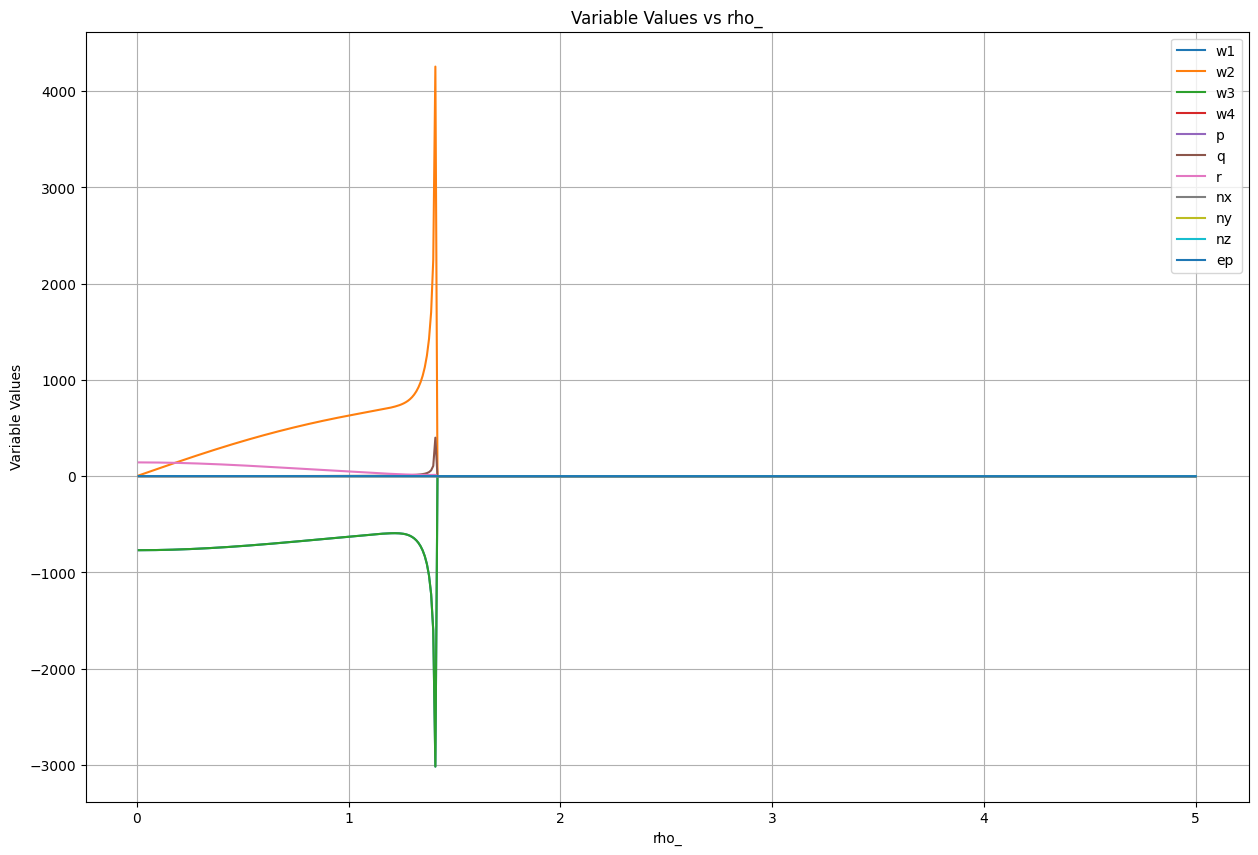

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming solve_equilibrium_equations is defined and accessible
def plot_equilibrium_equations():
    rho_values = np.arange(0.01, 5.01, 0.01)  # rho_ from 0.01 to 5.00
    initial_guess = 0.01  # Initial guess for the first iteration
    results = {key: [] for key in ['w1', 'w2', 'w3', 'w4', 'p', 'q', 'r', 'nx', 'ny', 'nz', 'ep']}
    for rho_ in rho_values:
        __new_sol__ = solve_equilibrium_equations(failed_motor=4, rho_=rho_, initial_guess=initial_guess)
        new_sol = __new_sol__[0]
        obj_sol = __new_sol__[1]
        initial_guess = abs(new_sol['ep'])  # Update initial guess to the last value of ep
        # if not obj_sol.success:
        #     initial_guess = rho_
        for key in results.keys():
            results[key].append(new_sol[key])
    
    # Plot each variable
    plt.figure(figsize=(15, 10))
    for key, values in results.items():
        plt.plot(rho_values, values, label=key)
    # plt.plot(rho_values, results['w1'], label='w1')
    
    plt.xlabel("rho_")
    plt.ylabel("Variable Values")
    plt.title("Variable Values vs rho_")
    plt.legend()
    plt.grid()
    plt.show()
    return results

results = plot_equilibrium_equations()


In [67]:
import numpy as np
import plotly.graph_objects as go

# Assuming solve_equilibrium_equations is defined and accessible
def plot_equilibrium_equations_interactive(columns = ['w1', 'w2', 'w3', 'w4', 'p', 'q', 'r', 'nx', 'ny', 'nz', 'ep']):
    rho_values = np.arange(0.01, 5.01, 0.01)  # rho_ from 0.01 to 5.00
    initial_guess = 0.01  # Initial guess for the first iteration
    results = {key: [] for key in columns}
    
    for rho_ in rho_values:
        __new_sol__ = solve_equilibrium_equations(failed_motor=4, rho_=rho_, initial_guess=initial_guess)
        new_sol = __new_sol__[0]
        obj_sol = __new_sol__[1]
        initial_guess = abs(new_sol['ep'])  # Update initial guess to the last value of ep
        for key in results.keys():
            results[key].append(new_sol[key])
    
    # Create an interactive plot
    fig = go.Figure()
    
    # Add traces for each variable
    for key, values in results.items():
        fig.add_trace(go.Scatter(
            x=rho_values, 
            y=values, 
            mode='lines', 
            name=key, 
            hovertemplate=key+': %{y:.4f} <br> rho_: %{x:.2f}<extra></extra>'
        ))
    
    # Set plot layout
    fig.update_layout(
        title="Variable Values vs rho_ (Interactive)",
        xaxis_title="rho_",
        yaxis_title="Variable Values",
        legend_title="Variables",
        template="plotly_white",
        width=1000,
        height=600
    )
    
    # Show the plot
    fig.show()
    return results

results = plot_equilibrium_equations_interactive()


The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  0.0025006959315127587  for rho_:  1.42
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.43
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.44
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.45
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.46
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.47
The iteration is not making good progress, as meas

In [68]:
plot_equilibrium_equations_interactive(columns=['r', 'q', 'w1'])
# plot_equilibrium_equations_interactive(columns=['r', 'w1'])

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  0.0025006959315127587  for rho_:  1.42
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.43
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.44
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.45
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.46
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations. for value of initial_guess:  1  for rho_:  1.47
The iteration is not making good progress, as meas

{'r': [np.float64(142.62878677712575),
  np.float64(142.58600455849952),
  np.float64(142.51472937077995),
  np.float64(142.4150039340958),
  np.float64(142.28688796704228),
  np.float64(142.13045809739614),
  np.float64(141.94580774775042),
  np.float64(141.73304699638487),
  np.float64(141.4923024137599),
  np.float64(141.22371687508556),
  np.float64(140.92744934948198),
  np.float64(140.60367466631044),
  np.float64(140.2525832593112),
  np.float64(139.8743808892436),
  np.float64(139.4692883457754),
  np.float64(139.03754112941968),
  np.float64(138.57938911436457),
  np.float64(138.09509619308295),
  np.float64(137.58493990365298),
  np.float64(137.04921104075055),
  np.float64(136.48821325131195),
  np.float64(135.90226261588927),
  np.float64(135.29168721674904),
  np.float64(134.6568266937787),
  np.float64(133.99803178928877),
  np.float64(133.31566388280316),
  np.float64(132.61009451694338),
  np.float64(131.88170491551196),
  np.float64(131.13088549488575),
  np.float64(13

In [69]:
# get intersection of r and q curve
# index = rho_*100 - 1
x1_rho = 0.89
x2_rho = 0.90
x1_rho_index = int(x1_rho * 100 - 1)
x2_rho_index = int(x2_rho * 100 - 1)
x1_rho_index, x2_rho_index

(88, 89)

In [70]:
y1_r = results['r'][x1_rho_index]
y2_r = results['r'][x2_rho_index]
y1_r, y2_r

(np.float64(61.72262431582275), np.float64(60.422222154596014))

In [71]:
y1_q = results['q'][x1_rho_index]
y2_q = results['q'][x2_rho_index]
y1_q, y2_q

(np.float64(1.2826452392814738), np.float64(1.331567868577121))

In [72]:
x_intersection = (y1_q - y1_r)*(x2_rho - x1_rho)/(y2_r-y2_q + y1_q-y1_r) + x1_rho
x_intersection

np.float64(1.3379275820104226)

In [73]:
new_sol = solve_equilibrium_equations(failed_motor=4, rho_=1.32, initial_guess=1)[0]
new_sol

{'w1': np.float64(-667.370519365549),
 'w2': np.float64(880.9290855625246),
 'w3': np.float64(-667.370519365549),
 'w4': 0.0,
 'p': np.float64(-0.0),
 'q': np.float64(13.652046173120295),
 'r': np.float64(13.807531587661634),
 'nx': np.float64(-0.0),
 'ny': np.float64(0.7030916322910244),
 'nz': np.float64(0.7110992593178476),
 'ep': np.float64(0.05150082437278533)}

In [74]:
# Calculate a_const
a_const = ((Ixx_t - Izz_t) * new_sol['r'] / Ixx_t) + Izz_P * (new_sol['w1'] + new_sol['w2'] + new_sol['w3'] + new_sol['w4']) / Ixx_t

# Define matrices A, B, Q, R
# Define the matrix A without deltat
A = np.array([
    [1,        a_const,  0,        0        ],
    [-a_const, 1,        0,        0        ],
    [0,        -new_sol['nz'],   1,        new_sol['r']     ],
    [new_sol['nz'],    0,        -new_sol['r'],    1        ]
])

B = np.array([
    [0, l / Ixx_t],
    [l / Ixx_t, 0],
    [0, 0],
    [0, 0]
])

# builder = DiagramBuilder()
# system = builder.AddSystem(LinearSystem(A, B, np.zeros((2,)), np.zeros((1,)), time_period=1.0))
# context = system.CreateDefaultContext()

# Ensure Q is symmetric
Q = np.array([
    # [5, 0, 0, 0],
    # [0, 5, 0, 0],
    # [0, 0, 100, 0],
    # [0, 0, 0, 100]
    [500, 0, 0, 0],
    [0, 80, 0, 0],
    [0, 0, 800, 0],
    [0, 0, 0, 5000]
    # [400, 0, 0, 0],
    # [0, 50, 0, 0],
    # [0, 0, 500, 0],
    # [0, 0, 0, 4000]
    # [250, 0, 0, 0],
    # [0, 40, 0, 0],
    # [0, 0, 400, 0],
    # [0, 0, 0, 800]
])

R = np.array([
    # [10, 0],
    # [0, 10]
    # [1, 0],
    # [0, 1]
    [35, 0],
    [0, 35]
])

# Calculate the LQR gain
result = LinearQuadraticRegulator(A, B, Q, R)


# Print the result[0] in C++ style initialization format
# result_cpp_format = "K = {" + ",".join(
#     [" {" + ", ".join(f"{x:.8e}" for x in row) + "} " for row in result[0]]
# ) + "}; "
# print(result_cpp_format)
print('K = {{', ", ".join(map(str, result[0][0])), '}, \n     {', ", ".join(map(str, result[0][1])) , '}};')



K = {{ -0.2933665382353208, 2.262488091733113, -15.424404213739042, -9.183808675393825 }, 
     { 3.8695272638412597, -0.2933665382353237, -8.627435916948276, 5.910235135594249 }};


In [75]:
result

(array([[ -0.29336654,   2.26248809, -15.42440421,  -9.18380868],
        [  3.86952726,  -0.29336654,  -8.62743592,   5.91023514]]),
 array([[ 1.17383995e+01, -8.89941691e-01, -2.61717473e+01,
          1.79289863e+01],
        [-8.89941691e-01,  6.86336789e+00, -4.67906819e+01,
         -2.78595312e+01],
        [-2.61717473e+01, -4.67906819e+01,  2.45526325e+03,
         -1.89083213e+02],
        [ 1.79289863e+01, -2.78595312e+01, -1.89083213e+02,
          2.19805380e+03]]))

In [76]:
f1 = KF * new_sol['w1'] * new_sol['w1']
f2 = KF * new_sol['w2'] * new_sol['w2']
f3 = KF * new_sol['w3'] * new_sol['w3']
f4 = KF * new_sol['w4'] * new_sol['w4']
f1, f2, f3, f4

(np.float64(7.601863653229764),
 np.float64(13.245487229387543),
 np.float64(7.601863653229764),
 0.0)

In [77]:
max_f = KF * 2000**2
max_f, max_f/2, 

(68.2725353529588, 34.1362676764794)

In [78]:
mass * 9.81

20.250858461538463

In [79]:
# bkcd
del_z = 0.01
(1+math.exp(del_z))**2 / (2*(8.83-1.5)*math.exp(del_z))

0.2728581173829015

In [80]:
import numpy as np
import plotly.graph_objects as go

# Define the function to plot
def function(x):
    return np.sin(x)

# Generate x and y values
x = np.linspace(-10, 10, 500)
y = function(x)

# Create the interactive plot
fig = go.Figure()

# Add a trace for the function
fig.add_trace(go.Scatter(
    x=x, 
    y=y, 
    mode='lines', 
    line=dict(color='blue'),
    name="y = sin(x)",
    hovertemplate='x: %{x:.2f}<br>y: %{y:.2f}'
))

# Customize layout to look like Desmos
fig.update_layout(
    title="Desmos-like Interactive Plot",
    xaxis=dict(
        title="X-axis",
        zeroline=True,
        showgrid=True,
        linecolor='black',
        mirror=True
    ),
    yaxis=dict(
        title="Y-axis",
        zeroline=True,
        showgrid=True,
        linecolor='black',
        mirror=True
    ),
    plot_bgcolor="white",
    width=800,
    height=600
)

# Show the plot
fig.show()
